## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

In [335]:
import json
import numpy as np
import pandas as pd
import re, nltk, string
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.stem.wordnet import WordNetLemmatizer

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

In [336]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [337]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [338]:
# Installing wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# Import pickle to save and load the model
import pickle

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [339]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [340]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [341]:
# Opening JSON file
f = open('gdrive/MyDrive/complaints-2021-05-14_08_16.json') # Write the path to your data file and load it

# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [342]:
# Inspect the dataframe to understand the given data.
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [343]:
#print the column names
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [344]:
#Assign new column names
df.columns = ['index', 'type', 'id', 'score', 'tags', 'zip_code','complaint_id',
              'issue', 'date_received','state', 'consumer_disputed', 'product',
              'company_response', 'company', 'submitted_via','date_sent_to_company',
              'company_public_response','sub_product', 'timely',
              'complaint_what_happened', 'sub_issue','consumer_consent_provided']

In [345]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [346]:
#Assign nan in place of blanks in the complaints column
df[df.loc[:, 'complaint_what_happened'] == ''] = np.nan

In [347]:
df[df.loc[:, 'complaint_what_happened'] == '']

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided


In [348]:
# check the dimension
df.shape

(78313, 22)

In [349]:
#Remove all rows where complaints column is nan
df = df[~df['complaint_what_happened'].isnull()]
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [350]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(sentence):
    sentence = sentence.lower() # Text to lowercase
    pattern = '[^\w\s]' # Removing punctuation
    sentence = re.sub(pattern, '', sentence)
    pattern = '\w*\d\w*' # Removing words with numbers in between
    sentence = re.sub(pattern, '', sentence)
    return sentence

In [351]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df['complaint_what_happened'] = df['complaint_what_happened'].astype(str) # Convert complaint_what_happened column to string
df_clean = pd.DataFrame(df['complaint_what_happened'].apply(clean_text))

In [352]:
df_clean

,complaint_what_happened
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...
10,chase card was reported on however fraudulent...
11,on while trying to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...
...,...
78303,after being a chase card customer for well ove...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...
78310,i am not familiar with xxxx pay and did not un...
78311,i have had flawless credit for yrs ive had ch...


In [353]:
#Write your function to Lemmatize the texts
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    words = text.split()
    words = [lemmatizer.lemmatize(word,pos='v') for word in words]
    return ' '.join(words)

In [354]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [355]:
#Adding a column to df_clean' that will have  the lemmatized complaints
df_clean['complaint_lemmatized'] = df_clean['complaint_what_happened'].apply(lemmatize_words)

In [356]:
df_clean

,complaint_what_happened,complaint_lemmatized
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade my xxxx xxxx card in and be tell by ...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent app...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket i come...
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...
...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas my xxxx xxxx...
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...
78311,i have had flawless credit for yrs ive had ch...,i have have flawless credit for yrs ive have c...


In [357]:
df_clean['tokenized'] = df_clean['complaint_lemmatized'].str.lower().apply(nltk.word_tokenize)

In [358]:
df_clean['tagged'] = df_clean['tokenized'].apply(nltk.pos_tag)

In [359]:
df_clean['complaint_POS_removed'] = df_clean['tagged'].apply(lambda x: [word for word, tag in x if tag in ['NN', 'NNS', 'NNP', 'NNPS']])

In [360]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,complaint_lemmatized,tokenized,tagged,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...,"[good, morning, my, name, be, xxxx, xxxx, and,...","[(good, JJ), (morning, NN), (my, PRP$), (name,...","[morning, name, xxxx, stop, bank, cardmember, ..."
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade my xxxx xxxx card in and be tell by ...,"[i, upgrade, my, xxxx, xxxx, card, in, and, be...","[(i, NN), (upgrade, VBP), (my, PRP$), (xxxx, J...","[i, card, agent, upgrade, date, agent, informa..."
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent app...,"[chase, card, be, report, on, however, fraudul...","[(chase, VB), (card, NN), (be, VB), (report, N...","[card, report, application, identity, consent,..."
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket i come...,"[on, while, try, to, book, a, xxxx, xxxx, tick...","[(on, IN), (while, IN), (try, NN), (to, TO), (...","[try, book, xxxx, ticket, i, offer, ticket, ca..."
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,"[my, grand, son, give, me, check, for, i, depo...","[(my, PRP$), (grand, JJ), (son, NN), (give, VB...","[son, deposit, chase, account, fund, bank, acc..."
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,"[after, be, a, chase, card, customer, for, wel...","[(after, IN), (be, VB), (a, DT), (chase, JJ), ...","[card, customer, decade, solicitations, credit..."
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas my xxxx xxxx...,"[on, wednesday, xxxxxxxx, i, call, chas, my, x...","[(on, IN), (wednesday, JJ), (xxxxxxxx, NNP), (...","[xxxxxxxx, i, call, chas, xxxx, visa, credit, ..."
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...,"[i, be, not, familiar, with, xxxx, pay, and, d...","[(i, RB), (be, VB), (not, RB), (familiar, JJ),...","[pay, risk, provide, consumers, bank, app, i, ..."
78311,i have had flawless credit for yrs ive had ch...,i have have flawless credit for yrs ive have c...,"[i, have, have, flawless, credit, for, yrs, iv...","[(i, NNS), (have, VBP), (have, VBP), (flawless...","[i, credit, credit, card, chase, freedom, xxxx..."


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [361]:
# Write your code here to visualise the data according to the 'Complaint' character length

#### Find the top 40 words by frequency among all the articles after processing the text.

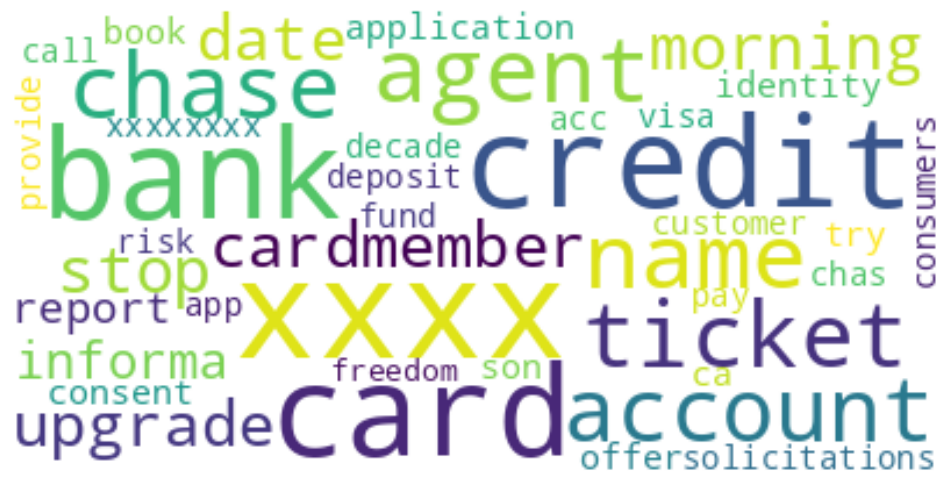

In [362]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=60, max_words=40,
                      background_color="white", random_state=100,
                      stopwords=stopwords).generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=[12,12])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [363]:
df_clean

,complaint_what_happened,complaint_lemmatized,tokenized,tagged,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...,"[good, morning, my, name, be, xxxx, xxxx, and,...","[(good, JJ), (morning, NN), (my, PRP$), (name,...","[morning, name, xxxx, stop, bank, cardmember, ..."
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade my xxxx xxxx card in and be tell by ...,"[i, upgrade, my, xxxx, xxxx, card, in, and, be...","[(i, NN), (upgrade, VBP), (my, PRP$), (xxxx, J...","[i, card, agent, upgrade, date, agent, informa..."
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent app...,"[chase, card, be, report, on, however, fraudul...","[(chase, VB), (card, NN), (be, VB), (report, N...","[card, report, application, identity, consent,..."
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket i come...,"[on, while, try, to, book, a, xxxx, xxxx, tick...","[(on, IN), (while, IN), (try, NN), (to, TO), (...","[try, book, xxxx, ticket, i, offer, ticket, ca..."
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,"[my, grand, son, give, me, check, for, i, depo...","[(my, PRP$), (grand, JJ), (son, NN), (give, VB...","[son, deposit, chase, account, fund, bank, acc..."
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,"[after, be, a, chase, card, customer, for, wel...","[(after, IN), (be, VB), (a, DT), (chase, JJ), ...","[card, customer, decade, solicitations, credit..."
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas my xxxx xxxx...,"[on, wednesday, xxxxxxxx, i, call, chas, my, x...","[(on, IN), (wednesday, JJ), (xxxxxxxx, NNP), (...","[xxxxxxxx, i, call, chas, xxxx, visa, credit, ..."
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...,"[i, be, not, familiar, with, xxxx, pay, and, d...","[(i, RB), (be, VB), (not, RB), (familiar, JJ),...","[pay, risk, provide, consumers, bank, app, i, ..."
78311,i have had flawless credit for yrs ive had ch...,i have have flawless credit for yrs ive have c...,"[i, have, have, flawless, credit, for, yrs, iv...","[(i, NNS), (have, VBP), (have, VBP), (flawless...","[i, credit, credit, card, chase, freedom, xxxx..."


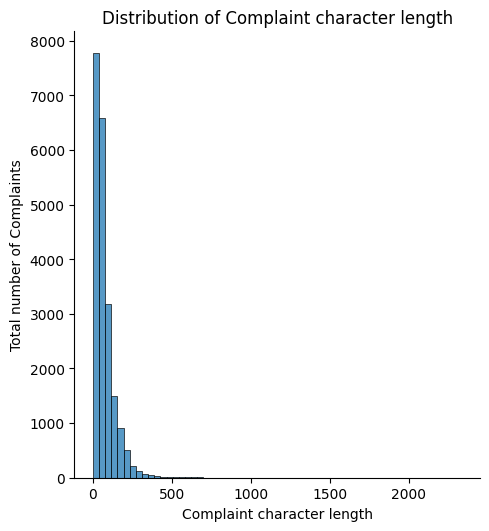

In [364]:
#visualise the data according to the 'Complaint' character length
char_len = [len(each_sent) for each_sent in df_clean['complaint_POS_removed']]

sns.displot(char_len, kind='hist', bins=60)
plt.xlabel("Complaint character length")
plt.ylabel("Total number of Complaints")
plt.title("Distribution of Complaint character length")
plt.show()

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [365]:
# Creating a function to extract top ngrams(unigram/bigram/trigram) based on the function inputs
def get_top_ngrams(text, n=None, ngram=(1,1)):
  vec = CountVectorizer(stop_words='english', ngram_range=ngram).fit(text)
  bagofwords = vec.transform(text)
  sum_words = bagofwords.sum(axis=0)
  words_frequency = [(word, sum_words[0, index]) for word, index in vec.vocabulary_.items()]
  words_frequency = sorted(words_frequency, key = lambda x: x[1], reverse=True)
  return words_frequency[:n]

In [366]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
top_30words = get_top_ngrams(df_clean['complaint_POS_removed'].astype('U'), n=30, ngram=(1,1))
df_unigram = pd.DataFrame(top_30words, columns=['unigram', 'count'])

In [367]:
#Print the top 10 words in the unigram frequency
df_unigram

,unigram,count
0,xxxx,149848
1,chase,49489
2,account,47523
3,credit,34175
4,bank,30058
5,card,29310
6,xxxxxxxx,22578
7,time,16119
8,check,14867
9,charge,14821


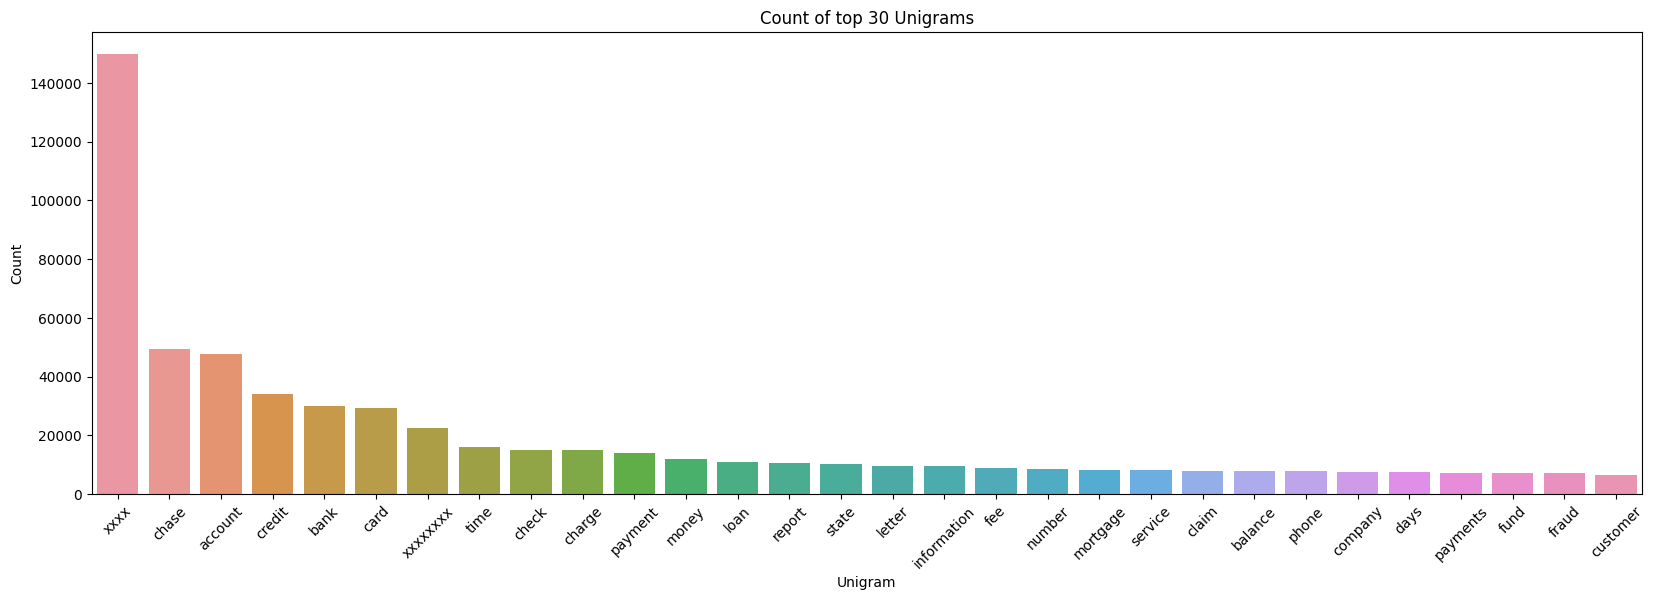

In [368]:
# Plotting top 30 Unigrams
plt.figure(figsize=[20,6])
sns.barplot(x=df_unigram['unigram'], y=df_unigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Unigram")
plt.ylabel("Count")
plt.title("Count of top 30 Unigrams")
plt.show()

In [369]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
top_30words = get_top_ngrams(df_clean['complaint_POS_removed'].astype('U'), n=30, ngram=(2,2))
df_bigram = pd.DataFrame(top_30words, columns=['bigram', 'count'])

In [370]:
#Print the top 10 words in the bigram frequency
df_bigram

,bigram,count
0,xxxx xxxx,68942
1,credit card,12784
2,credit report,4958
3,check account,4363
4,xxxx chase,3315
5,chase bank,3286
6,xxxxxxxx xxxx,3222
7,customer service,3066
8,account xxxx,3050
9,chase credit,2930


In [371]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
top_30words = get_top_ngrams(df_clean['complaint_POS_removed'].astype('U'), n=30, ngram=(3,3))
df_trigram = pd.DataFrame(top_30words, columns=['trigram', 'count'])

In [372]:
#Print the top 10 words in the trigram frequency
df_trigram

,trigram,count
0,xxxx xxxx xxxx,35171
1,chase credit card,1992
2,xxxxxxxx xxxx xxxx,1580
3,xxxx xxxx chase,1340
4,xxxx xxxx xxxxxxxx,1300
5,account xxxx xxxx,1229
6,xxxx credit card,1044
7,chase xxxx xxxx,1026
8,bank xxxx xxxx,1019
9,credit card account,1004


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [373]:
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].astype(str)
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('xxxx','')

In [374]:
#All masked texts has been removed
df_clean

,complaint_what_happened,complaint_lemmatized,tokenized,tagged,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...,"[good, morning, my, name, be, xxxx, xxxx, and,...","[(good, JJ), (morning, NN), (my, PRP$), (name,...","['morning', 'name', 'xxxx', 'stop', 'bank', 'c...","['morning', 'name', '', 'stop', 'bank', 'cardm..."
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade my xxxx xxxx card in and be tell by ...,"[i, upgrade, my, xxxx, xxxx, card, in, and, be...","[(i, NN), (upgrade, VBP), (my, PRP$), (xxxx, J...","['i', 'card', 'agent', 'upgrade', 'date', 'age...","['i', 'card', 'agent', 'upgrade', 'date', 'age..."
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent app...,"[chase, card, be, report, on, however, fraudul...","[(chase, VB), (card, NN), (be, VB), (report, N...","['card', 'report', 'application', 'identity', ...","['card', 'report', 'application', 'identity', ..."
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket i come...,"[on, while, try, to, book, a, xxxx, xxxx, tick...","[(on, IN), (while, IN), (try, NN), (to, TO), (...","['try', 'book', 'xxxx', 'ticket', 'i', 'offer'...","['try', 'book', '', 'ticket', 'i', 'offer', 't..."
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,"[my, grand, son, give, me, check, for, i, depo...","[(my, PRP$), (grand, JJ), (son, NN), (give, VB...","['son', 'deposit', 'chase', 'account', 'fund',...","['son', 'deposit', 'chase', 'account', 'fund',..."
...,...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,"[after, be, a, chase, card, customer, for, wel...","[(after, IN), (be, VB), (a, DT), (chase, JJ), ...","['card', 'customer', 'decade', 'solicitations'...","['card', 'customer', 'decade', 'solicitations'..."
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas my xxxx xxxx...,"[on, wednesday, xxxxxxxx, i, call, chas, my, x...","[(on, IN), (wednesday, JJ), (xxxxxxxx, NNP), (...","['xxxxxxxx', 'i', 'call', 'chas', 'xxxx', 'vis...","['', 'i', 'call', 'chas', '', 'visa', 'credit'..."
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...,"[i, be, not, familiar, with, xxxx, pay, and, d...","[(i, RB), (be, VB), (not, RB), (familiar, JJ),...","['pay', 'risk', 'provide', 'consumers', 'bank'...","['pay', 'risk', 'provide', 'consumers', 'bank'..."
78311,i have had flawless credit for yrs ive had ch...,i have have flawless credit for yrs ive have c...,"[i, have, have, flawless, credit, for, yrs, iv...","[(i, NNS), (have, VBP), (have, VBP), (flawless...","['i', 'credit', 'credit', 'card', 'chase', 'fr...","['i', 'credit', 'credit', 'card', 'chase', 'fr..."


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [375]:
#Write your code here to initialise the TfidfVectorizer
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [376]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])
dtm

<21072x7978 sparse matrix of type '<class 'numpy.float64'>'
	with 671351 stored elements in Compressed Sparse Row format>

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [377]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [378]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here

In [379]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

7978

In [380]:
H = nmf_model.components_       # Topic-term matrix

In [381]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,chase,deposit,branch,number,business,days,claim,transfer,cash,access
Topic 2,credit,card,report,account,chase,inquiry,score,inquiries,company,limit,information,debt,letter,balance,application
Topic 3,loan,mortgage,home,chase,modification,property,payments,time,letter,document,house,bank,years,foreclosure,rate
Topic 4,charge,card,chase,dispute,fee,fraud,purchase,claim,merchant,transaction,service,transactions,time,refund,phone
Topic 5,payment,payments,balance,fee,month,statement,pay,time,date,auto,account,days,chase,months,day


for each topic, we can give a label based on their products/services:
Topic 1 = Bank account services
Topic 2 = Credit card / Prepaid card
Topic 3 = Mortgages/loans
Topic 4 = Theft/Dispute reporting Topic 5 = Others

In [382]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)

In [383]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_results.argmax(axis=1)

In [384]:
df_clean.head()

,complaint_what_happened,complaint_lemmatized,tokenized,tagged,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...,"[good, morning, my, name, be, xxxx, xxxx, and,...","[(good, JJ), (morning, NN), (my, PRP$), (name,...","['morning', 'name', 'xxxx', 'stop', 'bank', 'c...","['morning', 'name', '', 'stop', 'bank', 'cardm...",0
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade my xxxx xxxx card in and be tell by ...,"[i, upgrade, my, xxxx, xxxx, card, in, and, be...","[(i, NN), (upgrade, VBP), (my, PRP$), (xxxx, J...","['i', 'card', 'agent', 'upgrade', 'date', 'age...","['i', 'card', 'agent', 'upgrade', 'date', 'age...",1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent app...,"[chase, card, be, report, on, however, fraudul...","[(chase, VB), (card, NN), (be, VB), (report, N...","['card', 'report', 'application', 'identity', ...","['card', 'report', 'application', 'identity', ...",1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket i come...,"[on, while, try, to, book, a, xxxx, xxxx, tick...","[(on, IN), (while, IN), (try, NN), (to, TO), (...","['try', 'book', 'xxxx', 'ticket', 'i', 'offer'...","['try', 'book', '', 'ticket', 'i', 'offer', 't...",1
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,"[my, grand, son, give, me, check, for, i, depo...","[(my, PRP$), (grand, JJ), (son, NN), (give, VB...","['son', 'deposit', 'chase', 'account', 'fund',...","['son', 'deposit', 'chase', 'account', 'fund',...",0


In [385]:
#Print the first 5 Complaint for each of the Topics
df_clean_5=df_clean.groupby('Topic').head(5)
df_clean_5.sort_values('Topic')

,complaint_what_happened,complaint_lemmatized,tokenized,tagged,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...,"[good, morning, my, name, be, xxxx, xxxx, and,...","[(good, JJ), (morning, NN), (my, PRP$), (name,...","['morning', 'name', 'xxxx', 'stop', 'bank', 'c...","['morning', 'name', '', 'stop', 'bank', 'cardm...",0
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,"[my, grand, son, give, me, check, for, i, depo...","[(my, PRP$), (grand, JJ), (son, NN), (give, VB...","['son', 'deposit', 'chase', 'account', 'fund',...","['son', 'deposit', 'chase', 'account', 'fund',...",0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,"[with, out, notice, jp, morgan, chase, restric...","[(with, IN), (out, RP), (notice, JJ), (jp, NN)...","['jp', 'chase', 'account', 'debit', 'card', 't...","['jp', 'chase', 'account', 'debit', 'card', 't...",0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,"[mishandle, of, this, account, by, chase, auto...","[(mishandle, NN), (of, IN), (this, DT), (accou...","['mishandle', 'account', 'auto', 'xxxx']","['mishandle', 'account', 'auto', '']",0
27,i opened an account with chase bank on xxxx an...,i open an account with chase bank on xxxx and ...,"[i, open, an, account, with, chase, bank, on, ...","[(i, NN), (open, VBP), (an, DT), (account, NN)...","['i', 'account', 'bank', 'xxxx', 'code', 'bonu...","['i', 'account', 'bank', '', 'code', 'bonus', ...",0
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade my xxxx xxxx card in and be tell by ...,"[i, upgrade, my, xxxx, xxxx, card, in, and, be...","[(i, NN), (upgrade, VBP), (my, PRP$), (xxxx, J...","['i', 'card', 'agent', 'upgrade', 'date', 'age...","['i', 'card', 'agent', 'upgrade', 'date', 'age...",1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent app...,"[chase, card, be, report, on, however, fraudul...","[(chase, VB), (card, NN), (be, VB), (report, N...","['card', 'report', 'application', 'identity', ...","['card', 'report', 'application', 'identity', ...",1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket i come...,"[on, while, try, to, book, a, xxxx, xxxx, tick...","[(on, IN), (while, IN), (try, NN), (to, TO), (...","['try', 'book', 'xxxx', 'ticket', 'i', 'offer'...","['try', 'book', '', 'ticket', 'i', 'offer', 't...",1
15,can you please remove inquiry,can you please remove inquiry,"[can, you, please, remove, inquiry]","[(can, MD), (you, PRP), (please, VB), (remove,...",['inquiry'],['inquiry'],1
23,i have a chase credit card which is incorrectl...,i have a chase credit card which be incorrectl...,"[i, have, a, chase, credit, card, which, be, i...","[(i, NNS), (have, VBP), (a, DT), (chase, NN), ...","['i', 'chase', 'credit', 'card', 'data', 'cred...","['i', 'chase', 'credit', 'card', 'data', 'cred...",1


In [386]:
df_clean_5.shape

(25, 7)

In [387]:
df_clean_5.loc[df_clean_5['Topic'] == 0] ## inspecting rows for Topic 1 - Bank Account services

,complaint_what_happened,complaint_lemmatized,tokenized,tagged,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...,"[good, morning, my, name, be, xxxx, xxxx, and,...","[(good, JJ), (morning, NN), (my, PRP$), (name,...","['morning', 'name', 'xxxx', 'stop', 'bank', 'c...","['morning', 'name', '', 'stop', 'bank', 'cardm...",0
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,"[my, grand, son, give, me, check, for, i, depo...","[(my, PRP$), (grand, JJ), (son, NN), (give, VB...","['son', 'deposit', 'chase', 'account', 'fund',...","['son', 'deposit', 'chase', 'account', 'fund',...",0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,"[with, out, notice, jp, morgan, chase, restric...","[(with, IN), (out, RP), (notice, JJ), (jp, NN)...","['jp', 'chase', 'account', 'debit', 'card', 't...","['jp', 'chase', 'account', 'debit', 'card', 't...",0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,"[mishandle, of, this, account, by, chase, auto...","[(mishandle, NN), (of, IN), (this, DT), (accou...","['mishandle', 'account', 'auto', 'xxxx']","['mishandle', 'account', 'auto', '']",0
27,i opened an account with chase bank on xxxx an...,i open an account with chase bank on xxxx and ...,"[i, open, an, account, with, chase, bank, on, ...","[(i, NN), (open, VBP), (an, DT), (account, NN)...","['i', 'account', 'bank', 'xxxx', 'code', 'bonu...","['i', 'account', 'bank', '', 'code', 'bonus', ...",0


In [388]:
df_clean_5.loc[df_clean_5['Topic'] == 2] ## inspecting rows for Topic 3 - Mortgages/loans

,complaint_what_happened,complaint_lemmatized,tokenized,tagged,complaint_POS_removed,Complaint_clean,Topic
43,chase sent me an email today with the innocuou...,chase send me an email today with the innocuou...,"[chase, send, me, an, email, today, with, the,...","[(chase, NN), (send, VB), (me, PRP), (an, DT),...","['chase', 'email', 'today', 'title', 'informat...","['chase', 'email', 'today', 'title', 'informat...",2
57,i have been trying to do a loan modification w...,i have be try to do a loan modification with c...,"[i, have, be, try, to, do, a, loan, modificati...","[(i, NNS), (have, VBP), (be, VB), (try, VBN), ...","['i', 'loan', 'modification', 'chase', 'runaro...","['i', 'loan', 'modification', 'chase', 'runaro...",2
73,i have wired through one of chase branches in ...,i have wire through one of chase branch in xxx...,"[i, have, wire, through, one, of, chase, branc...","[(i, NNS), (have, VBP), (wire, VBN), (through,...","['i', 'chase', 'branch', 'xxxx', 'reinstatemen...","['i', 'chase', 'branch', '', 'reinstatement', ...",2
81,i bought a new xxxx xxxx on xxxxxxxx from xxxx...,i buy a new xxxx xxxx on xxxxxxxx from xxxx xx...,"[i, buy, a, new, xxxx, xxxx, on, xxxxxxxx, fro...","[(i, JJ), (buy, VBP), (a, DT), (new, JJ), (xxx...","['xxxx', 'xxxx', 'xxxxxxxx', 'xxxx', 'xxxx', '...","['', '', '', '', '', '', '', 'loan', 'but', 't...",2
99,my name is xxxx xxxx i have missed a payment i...,my name be xxxx xxxx i have miss a payment in ...,"[my, name, be, xxxx, xxxx, i, have, miss, a, p...","[(my, PRP$), (name, NN), (be, VB), (xxxx, JJ),...","['name', 'xxxx', 'i', 'payment', 'days', 'i', ...","['name', '', 'i', 'payment', 'days', 'i', 'tim...",2


In [389]:
df_clean_5.loc[df_clean_5['Topic'] == 3] ## inspecting rows for Topic 4 - Theft/Dispute reporting

,complaint_what_happened,complaint_lemmatized,tokenized,tagged,complaint_POS_removed,Complaint_clean,Topic
21,on xxxx i made a payment to an online retail...,on xxxx i make a payment to an online retailer...,"[on, xxxx, i, make, a, payment, to, an, online...","[(on, IN), (xxxx, NN), (i, NNS), (make, VBP), ...","['xxxx', 'i', 'payment', 'online', 'retailer',...","['', 'i', 'payment', 'online', 'retailer', 'us...",3
30,to whom it may concern chase bank charged wron...,to whom it may concern chase bank charge wrong...,"[to, whom, it, may, concern, chase, bank, char...","[(to, TO), (whom, WP), (it, PRP), (may, MD), (...","['concern', 'bank', 'charge', 'fee', 'i', 'bal...","['concern', 'bank', 'charge', 'fee', 'i', 'bal...",3
32,my chase amazon card was declined for a cateri...,my chase amazon card be decline for a cater or...,"[my, chase, amazon, card, be, decline, for, a,...","[(my, PRP$), (chase, NN), (amazon, VB), (card,...","['chase', 'card', 'decline', 'cater', 'order',...","['chase', 'card', 'decline', 'cater', 'order',...",3
40,xxxx xxxx a sofa love seat table and chairs an...,xxxx xxxx a sofa love seat table and chair and...,"[xxxx, xxxx, a, sofa, love, seat, table, and, ...","[(xxxx, NN), (xxxx, VBZ), (a, DT), (sofa, JJ),...","['xxxx', 'love', 'seat', 'table', 'chair', 'ch...","['', 'love', 'seat', 'table', 'chair', 'charge...",3
45,i made a purchase with xxxx xxxx xxxx on in t...,i make a purchase with xxxx xxxx xxxx on in th...,"[i, make, a, purchase, with, xxxx, xxxx, xxxx,...","[(i, NNS), (make, VBP), (a, DT), (purchase, NN...","['i', 'purchase', 'xxxx', 'xxxx', 'xxxx', 'amo...","['i', 'purchase', '', '', '', 'amount', 'i', '...",3


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services = Topic 1 [Value = 0]
* Credit card or prepaid card = Topic 2 [Value = 1]
* Theft/Dispute Reporting = Topic 3 [Value = 2]
* Mortgage/Loan = Topic 4 [Value = 3]
* Others = Topic 5 [Value = 4]

In [390]:
#Create the dictionary of Topic names and Topics
Topic_names = { 0:"Bank account services", 1:"Credit card / Prepaid card", 2:"Mortgages/loans",
               3:"Theft/Dispute reporting", 4:"Others" }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [391]:
df_clean

,complaint_what_happened,complaint_lemmatized,tokenized,tagged,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...,"[good, morning, my, name, be, xxxx, xxxx, and,...","[(good, JJ), (morning, NN), (my, PRP$), (name,...","['morning', 'name', 'xxxx', 'stop', 'bank', 'c...","['morning', 'name', '', 'stop', 'bank', 'cardm...",Bank account services
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade my xxxx xxxx card in and be tell by ...,"[i, upgrade, my, xxxx, xxxx, card, in, and, be...","[(i, NN), (upgrade, VBP), (my, PRP$), (xxxx, J...","['i', 'card', 'agent', 'upgrade', 'date', 'age...","['i', 'card', 'agent', 'upgrade', 'date', 'age...",Credit card / Prepaid card
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent app...,"[chase, card, be, report, on, however, fraudul...","[(chase, VB), (card, NN), (be, VB), (report, N...","['card', 'report', 'application', 'identity', ...","['card', 'report', 'application', 'identity', ...",Credit card / Prepaid card
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket i come...,"[on, while, try, to, book, a, xxxx, xxxx, tick...","[(on, IN), (while, IN), (try, NN), (to, TO), (...","['try', 'book', 'xxxx', 'ticket', 'i', 'offer'...","['try', 'book', '', 'ticket', 'i', 'offer', 't...",Credit card / Prepaid card
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,"[my, grand, son, give, me, check, for, i, depo...","[(my, PRP$), (grand, JJ), (son, NN), (give, VB...","['son', 'deposit', 'chase', 'account', 'fund',...","['son', 'deposit', 'chase', 'account', 'fund',...",Bank account services
...,...,...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,"[after, be, a, chase, card, customer, for, wel...","[(after, IN), (be, VB), (a, DT), (chase, JJ), ...","['card', 'customer', 'decade', 'solicitations'...","['card', 'customer', 'decade', 'solicitations'...",Credit card / Prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas my xxxx xxxx...,"[on, wednesday, xxxxxxxx, i, call, chas, my, x...","[(on, IN), (wednesday, JJ), (xxxxxxxx, NNP), (...","['xxxxxxxx', 'i', 'call', 'chas', 'xxxx', 'vis...","['', 'i', 'call', 'chas', '', 'visa', 'credit'...",Theft/Dispute reporting
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...,"[i, be, not, familiar, with, xxxx, pay, and, d...","[(i, RB), (be, VB), (not, RB), (familiar, JJ),...","['pay', 'risk', 'provide', 'consumers', 'bank'...","['pay', 'risk', 'provide', 'consumers', 'bank'...",Theft/Dispute reporting
78311,i have had flawless credit for yrs ive had ch...,i have have flawless credit for yrs ive have c...,"[i, have, have, flawless, credit, for, yrs, iv...","[(i, NNS), (have, VBP), (have, VBP), (flawless...","['i', 'credit', 'credit', 'card', 'chase', 'fr...","['i', 'credit', 'credit', 'card', 'chase', 'fr...",Others


In [392]:
df_clean.shape

(21072, 7)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [393]:
#Create the dictionary again of Topic names and Topics
Topic_names = { "Bank account services":0, "Credit card / Prepaid card":1, "Mortgages/loans":2,
                   "Theft/Dispute reporting":3, "Others":4 }
#Replace Topics with Topic Names
df_clean['Topic_num'] = df_clean['Topic'].map(Topic_names)

In [394]:
df_clean

,complaint_what_happened,complaint_lemmatized,tokenized,tagged,complaint_POS_removed,Complaint_clean,Topic,Topic_num
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...,"[good, morning, my, name, be, xxxx, xxxx, and,...","[(good, JJ), (morning, NN), (my, PRP$), (name,...","['morning', 'name', 'xxxx', 'stop', 'bank', 'c...","['morning', 'name', '', 'stop', 'bank', 'cardm...",Bank account services,0
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade my xxxx xxxx card in and be tell by ...,"[i, upgrade, my, xxxx, xxxx, card, in, and, be...","[(i, NN), (upgrade, VBP), (my, PRP$), (xxxx, J...","['i', 'card', 'agent', 'upgrade', 'date', 'age...","['i', 'card', 'agent', 'upgrade', 'date', 'age...",Credit card / Prepaid card,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent app...,"[chase, card, be, report, on, however, fraudul...","[(chase, VB), (card, NN), (be, VB), (report, N...","['card', 'report', 'application', 'identity', ...","['card', 'report', 'application', 'identity', ...",Credit card / Prepaid card,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket i come...,"[on, while, try, to, book, a, xxxx, xxxx, tick...","[(on, IN), (while, IN), (try, NN), (to, TO), (...","['try', 'book', 'xxxx', 'ticket', 'i', 'offer'...","['try', 'book', '', 'ticket', 'i', 'offer', 't...",Credit card / Prepaid card,1
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,"[my, grand, son, give, me, check, for, i, depo...","[(my, PRP$), (grand, JJ), (son, NN), (give, VB...","['son', 'deposit', 'chase', 'account', 'fund',...","['son', 'deposit', 'chase', 'account', 'fund',...",Bank account services,0
...,...,...,...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,"[after, be, a, chase, card, customer, for, wel...","[(after, IN), (be, VB), (a, DT), (chase, JJ), ...","['card', 'customer', 'decade', 'solicitations'...","['card', 'customer', 'decade', 'solicitations'...",Credit card / Prepaid card,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas my xxxx xxxx...,"[on, wednesday, xxxxxxxx, i, call, chas, my, x...","[(on, IN), (wednesday, JJ), (xxxxxxxx, NNP), (...","['xxxxxxxx', 'i', 'call', 'chas', 'xxxx', 'vis...","['', 'i', 'call', 'chas', '', 'visa', 'credit'...",Theft/Dispute reporting,3
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...,"[i, be, not, familiar, with, xxxx, pay, and, d...","[(i, RB), (be, VB), (not, RB), (familiar, JJ),...","['pay', 'risk', 'provide', 'consumers', 'bank'...","['pay', 'risk', 'provide', 'consumers', 'bank'...",Theft/Dispute reporting,3
78311,i have had flawless credit for yrs ive had ch...,i have have flawless credit for yrs ive have c...,"[i, have, have, flawless, credit, for, yrs, iv...","[(i, NNS), (have, VBP), (have, VBP), (flawless...","['i', 'credit', 'credit', 'card', 'chase', 'fr...","['i', 'credit', 'credit', 'card', 'chase', 'fr...",Others,4


In [395]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened', 'Topic_num']]

In [396]:
training_data

,complaint_what_happened,Topic_num
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in and was told ...,1
10,chase card was reported on however fraudulent...,1
11,on while trying to book a xxxx xxxx ticket ...,1
14,my grand son give me check for i deposit it i...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,3
78310,i am not familiar with xxxx pay and did not un...,3
78311,i have had flawless credit for yrs ive had ch...,4


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [397]:

#Write your code to get the Vector count
vect = CountVectorizer()
X_train_cnt = vect.fit_transform(training_data['complaint_what_happened'])
#Save word vector
pickle.dump(vect.vocabulary_, open("count_vector.pk1", "wb"))
#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_cnt)
#Save tfidf
pickle.dump(tfidf_transformer, open('tfidf.pk1', "wb"))

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [398]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

In [399]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic_num'], test_size=0.25, random_state=42)

**Logistic Regression**

In [400]:
logreg = LogisticRegression(random_state=42, solver='liblinear').fit(X_train, y_train)

In [401]:
#Getting the score of the base model
logreg.score(X_test, y_test)

0.9185649202733486

**HyperParameter Tuning**

In [402]:
logreg_grid = {"C": [100, 10, 5, 4, 3, 2, 1, 1.0, 0.1, 0.01],
                "solver": ["liblinear"]}
# Setup grid hyperparameter search for LogisticRegression
logreg_hpt = GridSearchCV(LogisticRegression(random_state=42),
                                param_grid=logreg_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
logreg_hpt.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [403]:
#Check best parameters
logreg_hpt.best_params_

{'C': 3, 'solver': 'liblinear'}

In [404]:
#Evaluating the tuned model
logreg_hpt.score(X_test, y_test)

0.9263477600607442

By using the hyperparameter tuning, we achieve an accuracy of 92.63%, the model is improved compared to the previous accuracy of 91.86%.

In [405]:
#Save Logistic Regression Model
pickle.dump(logreg_hpt, open("logreg_model.pk1", "wb"))

**Model Evaluation**

In [406]:
#Load pickled model
logreg_model = pickle.load(open("logreg_model.pk1", "rb"))

In [407]:
#Make predictions on test data
y_pred = logreg_model.predict(X_test)

In [408]:
#Print Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[1233   22    9   30    1]
 [  20 1230    5   46    6]
 [  17   14  853   11    6]
 [  52   47   18 1075    7]
 [  16   23   11   27  489]]


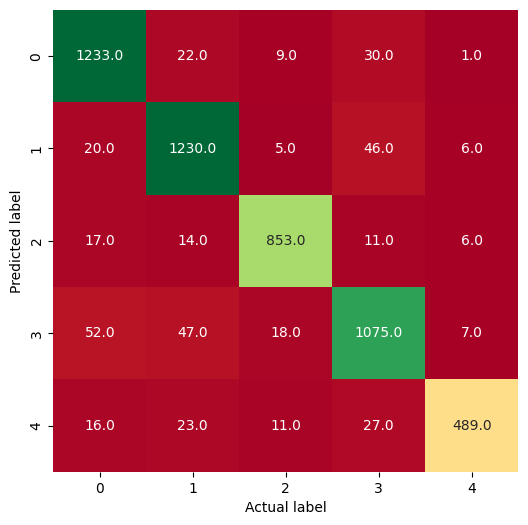

In [409]:
#Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                 annot=True,
                 cbar=False,
                 cmap="RdYlGn", fmt = '0.1f')
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.show()

In [410]:
Topicnames_target = ["Bank account services",
                     "Credit card / Prepaid card",
                     "Mortgages/loans",
                     "Theft/Dispute reporting",
                     "Others"]

In [411]:
#Print Classification Report
print(classification_report(y_test, y_pred, target_names = Topicnames_target))

                            precision    recall  f1-score   support

     Bank account services       0.92      0.95      0.94      1295
Credit card / Prepaid card       0.92      0.94      0.93      1307
           Mortgages/loans       0.95      0.95      0.95       901
   Theft/Dispute reporting       0.90      0.90      0.90      1199
                    Others       0.96      0.86      0.91       566

                  accuracy                           0.93      5268
                 macro avg       0.93      0.92      0.93      5268
              weighted avg       0.93      0.93      0.93      5268



The overall accuracy of the Logistic Regression model is 93%.
Precision are 93% and  Recall 92%.
This is very good model.

**Decision Tree**

In [412]:
# Import DecisionTreeClassifier from sklearn
from sklearn.tree import DecisionTreeClassifier

In [413]:
# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic_num'], test_size=0.25, random_state=42)

In [414]:
dt = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

In [415]:
#Get the score of the base model
dt.score(X_test, y_test)

0.7818906605922551

This decision tree model has accurancy of 78.19%

**HyperParameter Tuning**

In [419]:
dt_grid = {"max_depth": [3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [420]:
#Set grid hyperparameter search for LogisticRegression
dt_hpt = GridSearchCV(DecisionTreeClassifier(random_state=42),
                                param_grid=dt_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
dt_hpt.fit(X_train, y_train);

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


In [421]:
#Check the best parameters
dt_hpt.best_params_

{'max_depth': 10, 'min_samples_leaf': 15, 'min_samples_split': 2}

In [422]:
#Evaluate the tuned model
dt_hpt.score(X_test, y_test)

0.7739179954441914

The tuned Decision Tree Model has accurancy of 77.39%, and this value is less than the previous Decision Tree Model with the accurancy of 78.19%.

In [423]:
# Save Decision Tree Model
pickle.dump(dt_hpt, open("dt_model.pk1", "wb"))

**Model Evaluation**

In [424]:
#Load pickled model
dt_model = pickle.load(open("dt_model.pk1", "rb"))

In [425]:
#Carry out predictions on test data
y_pred = dt_model.predict(X_test)

In [426]:
#Print Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[1037   69   21  149   19]
 [  42 1068   21  162   14]
 [  40   17  700  121   23]
 [ 141  113   17  908   20]
 [  53   61   26   62  364]]


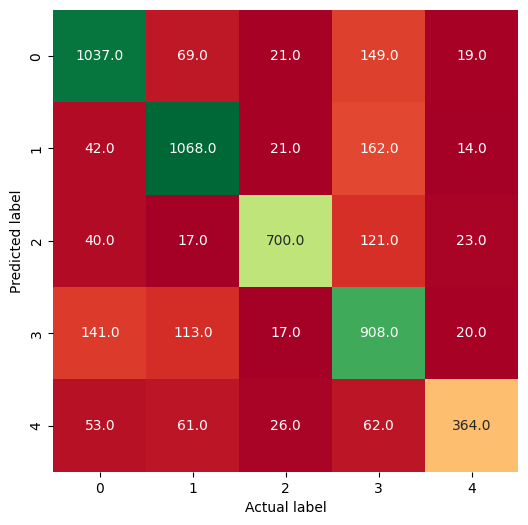

In [427]:
#Visualize the Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                 annot=True,
                 cbar=False,
                 cmap="RdYlGn", fmt = '0.1f')
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.show()

In [428]:
Topicnames_target = ["Bank account services",
                     "Credit card / Prepaid card",
                     "Mortgages/loans",
                     "Theft/Dispute reporting",
                     "Others"]

In [429]:
#Print Classification Report
print(classification_report(y_test, y_pred, target_names = Topicnames_target))

                            precision    recall  f1-score   support

     Bank account services       0.79      0.80      0.80      1295
Credit card / Prepaid card       0.80      0.82      0.81      1307
           Mortgages/loans       0.89      0.78      0.83       901
   Theft/Dispute reporting       0.65      0.76      0.70      1199
                    Others       0.83      0.64      0.72       566

                  accuracy                           0.77      5268
                 macro avg       0.79      0.76      0.77      5268
              weighted avg       0.78      0.77      0.78      5268



The overall accurancy for the Decision Tree Model is 77%
The Precision is 79%
The Recal is 76%
This model is poor compared with the Logistic Regression (93%)

**Conclusion:**

The Logistic Regression is the better model with the accurancy of 93% > 78% of the Decision Tree Model.

The Precision and Recall of The Logistic Regression model, 93% and 92% respectively, are better than the values of the Decision Tree Model 79% and 76% respectively.